In [85]:
import matplotlib.pyplot as plt
import numpy as np

In [86]:
from scipy.stats import lognorm

In [87]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

# Опционы и формула Блека-Шоулза
## Часть 1

В этой серии статей я выведу уравнение Блека-Шоулза для оценки европейского call-опциона классическим способом.

**DISCLAIMER:** в этих статьях я пытаюсь дать интуицию что вообще происходит, поэтому во многих местах я специально опускаю математические формальности, чтобы не усложнять понимание.

В предыдущей статье обсуждалось, что такое опционы и как они работают. Теперь давайте выведем формулу для оценки стоимости европейского call-опциона.

Не пугайтесь всех терминов по ходу статьи, я буду стараться понятно пояснять каждый термин.

## Содержание статьи
1. Наивное представление движения цены на рынке
2. Добавляем случайности - движение цены как случайный процесс
3. Нормальное и лог-нормальное распределение
4. Уравнение движения цены, когда она распределена лог-нормально
5. Проблемы полученного уравнения
6. Теорема Гирсанова и риск-нейтральная мера

## Наивное представление движения цены на рынке

Представим что у нас есть какой-нибудь рисковый актив, который торгуется на бирже. Например, стоимость эфира от времени.

Будем считать что мы ищем функцию, которая считает относительную стоимость (фактически **наше** S(t) **это** $\frac{S(t)}{S_0}$)

Мы хотим научиться делать какие-то предсказания по поводу будущей цены. В идеале хотелось бы иметь некоторую функцию $S(t)$, которая в любой момент времени говорила бы сколько будет стоить базовый актив. Это можно записать в дифференциальной форме:

$$dS(t) = \mu(t) dt$$
Проинтегрировав, можем получить

$$S(T) = S_0 + \int_0^T{\mu(t) dt}$$

То есть такая функция, которая нам бы сказала будущую цену.

**У такой модели есть проблема.**

Мы видим только историю, и никто не знает куда пойдёт цена эфира в будущем. Она может пойти на сколько-то процентов вверх, может вниз, в общем - может быть всё что угодно. А мы бы хотели найти функцию, которая детерминированно говорит стоимость в будущем.
Из-за кучи разных причин просто построить такую детерминированную функцию невозможно.


### Добавляем случайности

Раз нельзя говорить однозначно о том, какая цена будет в будущем, рассмотрим процесс, в котором есть две части: детерминированная и стохастическая часть.

$$dX(t) = \mu(t) dt + \sigma dW$$

$X(t)$ - значение случайного процесса в момент $t$ <br>
$\mu(t)$ - параметр, который называется дрифтом <br>
$\sigma$ - параметр волатильности <br>
$dW$ - это параметр, отвечающий за стохастическую часть. 

Процесс $W_t$ - называется винеровским. Здесь важно определение, поэтому приведу его. <br>

$W_t$ - винеровский, если:
- $W(0) = 0$ с вероятностью 1
- $W_t$ - процесс, у которого все приращения независимы
- $W_t - W_s \sim N(0, \sigma^2(t-s)),\:\: 0 \leq s \leq t \lt \infty $ - то есть разность распределена нормально.


То есть $dW \sim N(0, \sigma^2 dt)$


### Нормальное и лог-нормальное распределение

Если рассматривать процесс, описанный выше, в любой момент времени величина $X(t)$ будет распределена нормально (из-за добавки $\sigma dW$, которая распределена нормально).

Но эмпирически замечено, что в реальности распределение цены на базовый актив не нормальное, а **лог-нормальное.** Это такое распределение, логарифм которого распределен нормально. 

Это можно объяснить тем, что на рынках периодически случаются резкие обвалы, какие-то маловероятные события, которые обычно никто не принимает во внимание (у лог-нормального распределения "длинный хвост").

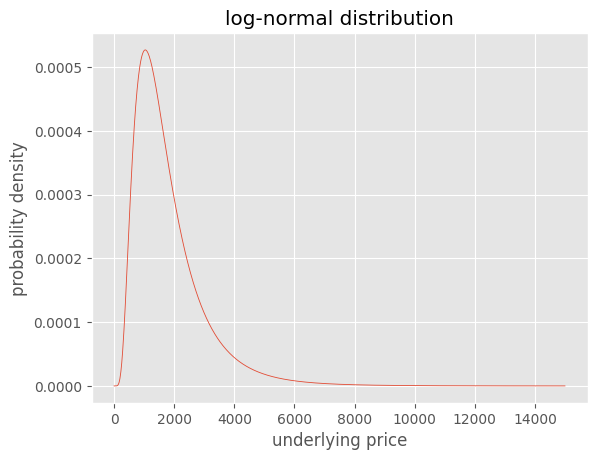

In [92]:
mean = 1500
stdev = 1000
phi = (stdev ** 2 + mean ** 2) ** 0.5
mu = np.log(mean ** 2 / phi)
sigma = (np.log(phi ** 2 / mean ** 2)) ** 0.5
data=np.random.lognormal(mu, sigma , 1000)

x = np.linspace(0, mean*10, 1000)
p = lognorm.pdf(x = x, scale = mean, s = sigma)
plt.plot(x, p)
plt.title('log-normal distribution')
plt.xlabel('underlying price')
plt.ylabel('probability density')
plt.show()

#### Уравнение для движения цены, когда она распределена лог-нормально:

Мы изначально записали процесс, который распределен **нормально**: $dX(t) = \mu(t) dt + \sigma dW$

Возьмем логарифм от процесса $X(t)$ и получим уравнение движения цены, распределение которой **лог-нормальное**:

$$ln(S_t) = X_t$$

$S_t$ - цена эфира в момент времени $t$.

$$d(X_t) = d(ln(S_t)) = \mu(t) dt + \sigma dW$$

Помним, что
$d(ln(S)) = \frac{1}{S} dS$

$$\frac{dS}{S} = \mu(t) dt + \sigma dW $$

В итоге получаем:

$$dS = \mu(t) S dt + \sigma S dW $$

Это уравнение называется уравнением **геометрического броуновского движения**.

Мы хотим решить это уравнение, то есть получить функцию $S(T) = \: ...$ (она будет недетерминированной из-за стохастической части)

#### Проблемы текущего уравнения

Сейчас есть две проблемы:
1. Мы не знаем ничего о дрифте $\mu(t)$. Интуитивно это параметр "риска" для конкретной акции, монеты, токена (но формально параметр риска определяется иначе, в дальнейшем будет формула). И как бы этот параметр может быть в общем случае зависящем от времени.
2. Полученное уравнение решать довольно сложно. Нельзя просто взять и проинтегрировать, потому что  в правой части стоят не константы, а функции $\mu(t)S$ и $\sigma S$. Разделить переменные, перенеся $S$ в левую часть и просто проинтегрировать тоже нельзя (немного позже увидим почему)

**Будем решать проблемы по очереди.**

Отойдем немного в сторону и вспомним, как вообще определяется стоимость безрискового актива. 

**Безрисковый актив** - это например бонды (= облигации). То есть такие инструменты, которые гарантированно приносят доход в будущем со ставкой $r$, называющейся безрисковой процентной ставкой. Например такие инструменты используют чтобы уберечься от инфляции.

Для упрощения будем считать, что безрисковая процентная ставка постоянна.

Тогда дифференциальное уравнение для стоимости безрискового актива (бонда) определяется уравнением

$$dB = r B dt$$

У бонда нету стохастической составляющей и дрифт равен $r$, который всем известен (например $r=0.1$ значит что безрисковая ставка равна 10% годовых).

Уравнение для цены рискового актива определялось так: $dS = \mu(t) S dt + \sigma S dW$.

Давайте представим, что было бы, если наш параметр $\mu$ - не произвольная функция, а например безрисковая ставка $r$.

То есть если бы наше уравнение выглядело так:

$$dS = r S dt + \sigma S dW$$

Тогда у нас стало бы на 1 неизвестную величину меньше и можно было бы уже пытаться решить это уравнение (т.е. перейти к "проблеме 2")

##### В общем, было бы круто избавиться от неизвестного дрифта. Но можно можно ли как-то это сделать?

Оказывается, да!

**Теорема Гирсанова** позволяет это сделать.



Если вспомнить мат анализ (и опустить доп условия теорем), есть теорема, которая позволяет переходить между мерами (теорема Радона-Никодима), и "коэффициентом перехода" между мерами является производная Радона-Никодима: 

$$\frac{d\nu}{d\mu} = f(x)$$

$\nu$, $\mu$ - меры Лебега.

В нашем случае производная Радона-Никодима уже будет не вещественной функцией, а стохастическим процессом.

#### Теорема Гирсанова и риск-нейтральная мера

Фактически, из уравнения

$$dS = \mu(t) S dt + \sigma S dW, \: \: S_0 > 0$$

мы хотим получить

$$dS = r S dt + \sigma S dW$$

С первого взгляда кажется, что это невозможно. Оказывается, нам нужно просто перейти в другую вероятностную меру - "риск-нейтральную".


##### Сначала напомню, что такое мартингал.

**Мартингал** - это такой случайный процесс, в котором наилучшим предсказанием будущего значения является текущее значение.





**По теореме Гирсанова**, нам нужно найти такой процесс $\{Z_t\}_{t\in[0, T]}$, который бы являлся мартингалом, и тогда был бы производной Радона-Никодима для перехода в другую меру.

У нас есть уравнение в мере $P$:

$$dS = \mu(t) S dt + \sigma S dW, \: \: S_0 > 0$$

Но $S_t$ - не мартингал в мере $P$, потому что есть дрифт $\mu(t) S_t \neq 0$


Вспомним что уравнение для цены бонда определяется так:

$$dB_t = r B_t dt$$

#### Наша цель:
Найти такую производную Радона-Никодима, чтобы в новой мере $Q$ вообще никак не фигурировал параметр $\mu$.


**Давайте рассмотрим такой процесс**: <br>
$\{\frac{S_t}{B_t}\}$ - то есть движение цены в физической мере $P$, делённое на движение цены бонда (в бонде нет стохастической составляющей).

Окажется, что он является нужной нам производной Радона-Никодима для новой меры, в которой уже не будет параметра $\mu$.

Запишем дифференциальное уравнение для такого процесса. Применив лемму Ито для такого процесса, мы получаем:

$$d(\frac{S_t}{B_t}) = S_t d(\frac{1}{B_t}) + \frac{1}{B_t}dS_t + \frac{1}{2}dS_td(\frac{1}{B_t})$$

Подставляя уравнения для $dS_t$ и $dB_t$:

$$d(\frac{S_t}{B_t}) = -r\frac{S_t}{B_t}dt + (\frac{1}{B_t} - \frac{1}{2}r\frac{1}{B_t}dt)(\mu S_t dt + \sigma S_t dW_t)$$

Упрощая это выражение и сокращая члены степени выше $dt$, получаем окончательную формулу для процесса $\{\frac{S_t}{B_t}\}$:

$$d(\frac{S_t}{B_t}) = \sigma \frac{S_t}{B_t}(\frac{\mu - r}{\sigma}dt + dW_t)$$


#### А теперь самое главное

Заметим что если сделаем замену на: 

$$\tilde{dW_t} = \frac{\mu - r}{\sigma}dt + dW_t$$

то процесс

$$d(\frac{S_t}{B_t}) = \sigma \frac{S_t}{B_t}\tilde{dW_t}$$

будет являться мартингалом.

Посмотрим теперь, как будет выглядеть процесс $dS_t$ при такой замене меры.

Выражаем $dW_t$ через $\tilde{dW_t}$ и подставляем в уравнение для $dS_t$:

$$dS_t = \mu S_t dt + \sigma S_t dW $$

$$dS_t = \mu S dt + \sigma S (\tilde{dW_t} - \frac{\mu - r}{\sigma}dt)$$

$$dS_t = \mu(t) S dt + \sigma S (\tilde{dW_t} - \frac{\mu - r}{\sigma}dt)$$

В итоге получаем

$$dS_t = r S dt + \sigma S \tilde{dW_t}$$

$\tilde{dW_t}$ - винеровский процесс в мере $Q$

**Таким образом мы перешли в такую вероятностную меру, где неизвестный параметр $\mu$ становится равным процентной ставке $r$. Более того, если мы рассмотрим дисконтированную цену $S_T$ в такой мере, то такой процесс будет мартингалом.** Именно поэтому такая мера ещё называется **мартингальной**.

P.S. цена должна быть именно дисконтированной.


#### Итак, мы решили проблему 1.

Мы нашли меру, в которой дрифт из неизвестной функции $\mu$ превращается в безрисковую процентную ставку $r$.

#### Осталась проблема 2.

Теперь, когда неизвестной функции $\mu$ нет, можно решать получившееся уравнение.

$$dS_t = r S dt + \sigma S \tilde{dW_t}$$

Такой процесс называется геометрическим броуновским движением с постоянным дрифтом. 

**Как решить такое уравнение и уже вывести уравнение Блека-Шоулза, я расскажу в следующей статье.**

#### Спасибо что дочитали до конца:)


##### Мой twitter:
https://twitter.com/kirrya95

##### Мой telegram:
https://t.me/kirr_ya